In [13]:
import pandas as pd


df = pd.read_csv('compiled_optimization_data.csv')
BO_cols = ['sample','beta','conductivity_avg','DMSO_content_realized','concentration_realized','combustion_temp_realized','air_flow_rate_realized','spray_flow_rate_realized','spray_height_realized','num_passes_realized']
BO_data = df[BO_cols]
BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper
display(BO_data)

features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

# Data processcing
x = BO_data[features].to_numpy()
y = BO_data[target].to_numpy()


 /var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_99531/3351175618.py:7: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sample,beta,conductivity_avg,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0,random,1.749261e+06,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,1,random,1.848613e+06,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,2,random,1.156030e+06,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,3,random,1.267199e+06,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,4,random,0.000000e+00,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
172,175,4.00E+02,8.775937e+05,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,176,4.00E+02,1.089103e+06,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,177,SF,0.000000e+00,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,178,SF,0.000000e+00,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


In [16]:
import GPy
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('code')
import function as varsel


m = 7
# number of data points
n = 300
# Delta for KL method
delta = 0.0001
# number of quadrature points for VAR method
nquadr = 11
y = y.reshape(-1, 1)
# RBF kernel plus constant term
kernel = GPy.kern.RBF(input_dim=m, ARD=True) + GPy.kern.Bias(input_dim=m)
model = GPy.models.GPRegression(x, y, kernel)
model.optimize()

# ARD relevance value is the inverse of the length scale
rel_ARD = 1 / model.sum.rbf.lengthscale
print(rel_ARD)
# KL relevance value
rel_KL = varsel.KLrel(x, model, delta)
print(rel_KL)
# VAR relevance value
rel_VAR = varsel.VARrel(x, model, nquadr)
print(rel_VAR)

rel_ARD_nor = rel_ARD / np.max(rel_ARD)
rel_KL_nor = rel_KL / np.max(rel_KL)
rel_VAR_nor = rel_VAR / np.max(rel_VAR)

print(rel_ARD_nor)
print(rel_KL_nor)
print(rel_VAR_nor)

[5.31569010e+01 1.26513199e-02 5.99088352e-02 1.89865509e-02
 3.98628884e-02 6.57148702e-01 1.60384316e-01]
[9.30435694e+01 3.09001037e-04 1.02948261e-01 2.95148673e-02
 3.19756860e-04 7.67253600e-01 2.67242926e-01]
[4.73786700e-01 4.39230319e-06 3.81286867e-01 2.68617543e-02
 4.13076916e-04 1.79617552e-01 2.12046915e-01]
[1.00000000e+00 2.37999576e-04 1.12701896e-03 3.57179417e-04
 7.49909939e-04 1.23624344e-02 3.01718711e-03]
[1.00000000e+00 3.32103593e-06 1.10645219e-03 3.17215553e-04
 3.43663578e-06 8.24617547e-03 2.87223424e-03]
[1.00000000e+00 9.27063422e-06 8.04764816e-01 5.66958809e-02
 8.71862625e-04 3.79110583e-01 4.47557762e-01]


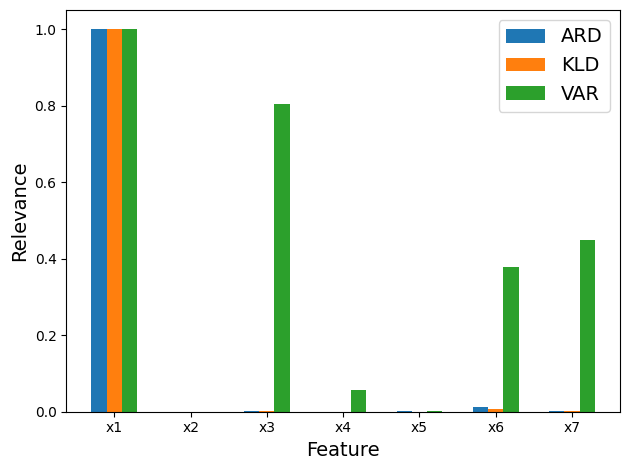

In [24]:
import matplotlib.pyplot as plt

# X-axis labels
x_labels = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']

num_bars = len(x_labels)


bar_width = 0.2  
x = np.arange(num_bars)  

# Plotting the grouped bar chart
plt.bar(x - bar_width, rel_ARD_nor, width=bar_width, label='ARD')
plt.bar(x, rel_KL_nor, width=bar_width, label='KLD')
plt.bar(x + bar_width, rel_VAR_nor, width=bar_width, label='VAR')


plt.xlabel('Feature', fontsize=14)
plt.ylabel('Relevance', fontsize=14)

# Adding x-ticks with proper labels
plt.xticks(x, x_labels)

# Adding legend
plt.legend(fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()